In [1]:
import numpy as np
import sympy as sp

import matplotlib.pyplot as plt
plt.rcParams.update({
    'text.latex.preamble': r'\usepackage{amsmath}',
    'text.usetex': True,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica']
})

# finite difference solver -- debunked!!!

In [59]:
def get_U_fde(dt,x,V=lambda t: np.full(t.shape[0],0),m=1):
    dx = x[1] - x[0]
    N  = x.shape[0]
    H  = -(np.diag(np.full(N-1,1),k=-1) - np.diag(np.full(N,2),k=0) + np.diag(np.full(N-1,1),k=1))/2/m/dx**2 + np.diag(V(x),k=0)
    H[0][:2]   = np.array([1,0])
    H[-1][-2:] = np.array([0,1])
    print(H)
    
    U = np.eye(N) - complex(0,dt)*H
    return U

def get_U_fdi(dt,x,V=lambda t: np.full(t.shape[0],0),m=1):
    dx = x[1] - x[0]
    N  = x.shape[0]
    H  = -(np.diag(np.full(N-1,1),k=-1) - np.diag(np.full(N,2),k=0) + np.diag(np.full(N-1,1),k=1))/2/m/dx**2 + np.diag(V(x),k=0)
    H[0][:2]   = np.array([1,0])
    H[-1][-2:] = np.array([0,1])
    
    U = np.eye(N) + complex(0,dt)*H
    return U

In [60]:
def gauss_psi(x,t,a=1,m=1):
    gam = complex(1,2*a*t/m)
    return (2*a/np.pi)**(1/4)*1/np.sqrt(gam)*np.exp(-a*x**2/gam)

test explicit evolution

In [61]:
x  = np.linspace(-10,10,50)
dx = x[1] - x[0]

x0,sig = 0,1
psi0    = (2*np.pi*sig**2)**(-1/4)*np.exp(-(x-x0)**2/4/sig**2)

dt = 0.001
print(dt/dx**2)
U  = get_U_fde(dt,x)
np.abs(np.linalg.eigvals(U))

0.006002500000000012
[[ 1.       0.       0.      ...  0.       0.       0.     ]
 [-3.00125  6.0025  -3.00125 ...  0.       0.       0.     ]
 [ 0.      -3.00125  6.0025  ...  0.       0.       0.     ]
 ...
 [ 0.       0.       0.      ...  6.0025  -3.00125  0.     ]
 [ 0.       0.       0.      ... -3.00125  6.0025  -3.00125]
 [ 0.       0.       0.      ...  0.       0.       1.     ]]


array([1.00007191, 1.00007147, 1.00007073, 1.00006972, 1.00006843,
       1.00006689, 1.0000651 , 1.00006308, 1.00006086, 1.00005846,
       1.00005589, 1.00005319, 1.00005038, 1.00004748, 1.00004452,
       1.00004153, 1.00003853, 1.00003555, 1.00003261, 1.00002972,
       1.00002692, 1.00002422, 1.00002164, 1.00001919, 1.00001688,
       1.00001472, 1.00001272, 1.00001089, 1.00000922, 1.00000772,
       1.        , 1.        , 1.00000001, 1.00000002, 1.00000005,
       1.0000001 , 1.00000018, 1.0000003 , 1.00000047, 1.00000071,
       1.00000103, 1.00000143, 1.00000193, 1.00000255, 1.00000638,
       1.0000033 , 1.0000052 , 1.00000418, 1.0000005 , 1.0000005 ])

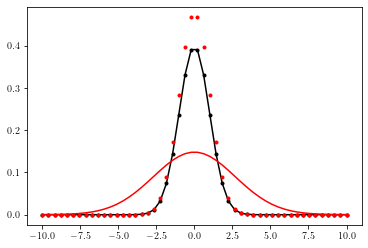

In [62]:
# for _ in rho[0]:
rho0 = np.abs(psi0)**2
plt.plot(x,rho0,'k.')
temp = gauss_psi(x,0,a=1/4/sig**2)
plt.plot(x,np.real(temp*temp.conjugate()),'k-')

Nt = 5000
psi = (U**Nt)@psi0
rho = np.abs(psi)**2
plt.plot(x,rho,'r.')
temp = gauss_psi(x,Nt*dt,a=1/4/sig**2)
plt.plot(x,np.abs(temp)**2,'r-')


plt.show()

test implicit evolution

In [67]:
x  = np.linspace(-10,10,100)
dx = x[1] - x[0]

x0,sig = 0,1
psi0    = (2*np.pi*sig**2)**(-1/4)*np.exp(-(x-x0)**2/4/sig**2)

dt = 0.001
print(dt/dx**2)
U = get_U_fdi(dt,x)
print(np.amax(np.abs(U*U.conjugate().T - np.eye(x.size))))
np.abs(1/np.linalg.eigvals(U))

0.024502499999999903
0.000600372506250002


array([1.        , 1.        , 0.99999999, 0.99999998, 0.99999995,
       0.9999999 , 0.99880202, 0.99880382, 0.99880682, 0.99881102,
       0.99999982, 0.99999969, 0.9988164 , 0.99882294, 0.99883063,
       0.99883946, 0.99999925, 0.99999789, 0.99999717, 0.99999846,
       0.99999629, 0.99999522, 0.99886041, 0.99889969, 0.99888559,
       0.99999395, 0.99891476, 0.99994027, 0.99994707, 0.99993291,
       0.99997709, 0.99992496, 0.99893074, 0.99997325, 0.99995331,
       0.99998052, 0.99991641, 0.99894762, 0.99990724, 0.99896533,
       0.99932526, 0.99930057, 0.99934996, 0.99987587, 0.99986409,
       0.99927594, 0.9993746 , 0.9992514 , 0.99947176, 0.99985164,
       0.99944777, 0.9990869 , 0.99949547, 0.99983852, 0.99922702,
       0.99951886, 0.9995419 , 0.99982472, 0.99913209, 0.99910926,
       0.99969036, 0.99967073, 0.99970939, 0.99904378, 0.99965053,
       0.99972781, 0.99998626, 0.99956455, 0.99981024, 0.99974561,
       0.99906506, 0.99998357, 0.99915533, 0.99958676, 0.99979

1.000000000000002
0.5487060797057448


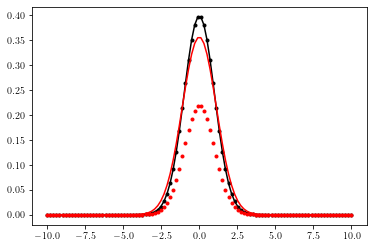

In [69]:
# for _ in rho[0]:
rho0 = np.abs(psi0)**2
print(np.sum(rho0)*dx)
plt.plot(x,rho0,'k.')
temp = gauss_psi(x,0,a=1/4/sig**2)
plt.plot(x,np.real(temp*temp.conjugate()),'k-')

Nt = 1000
psi = np.linalg.solve((U**Nt),psi0)
rho = np.abs(psi)**2
print(np.sum(rho)*dx)
plt.plot(x,rho,'r.')
temp = gauss_psi(x,Nt*dt,a=1/4/sig**2)
plt.plot(x,np.abs(temp)**2,'r-')

plt.show()

# FFT solver

In [113]:
def f(x,sig=1):
    return np.exp(-x**2/2/sig**2)/np.sqrt(2*np.pi*sig**2)

def F(k,sig=1):
    return np.exp(-k**2*sig**2/2)

In [117]:
x   = np.linspace(-10,10,3000)
dx  = x[1] - x[0]
f_  = f(x,sig=0.01)

k   = np.fft.fftfreq(x.size)*2*np.pi/dx
f_t = dx*np.exp(-complex(0,1)*k*x[0])*np.fft.fft(f_)
f_t,k = np.fft.fftshift(f_t),np.fft.fftshift(k)

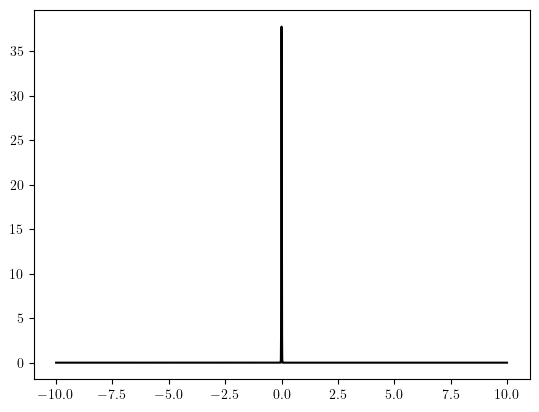

In [118]:
plt.plot(x,f_,'k-')

plt.show()

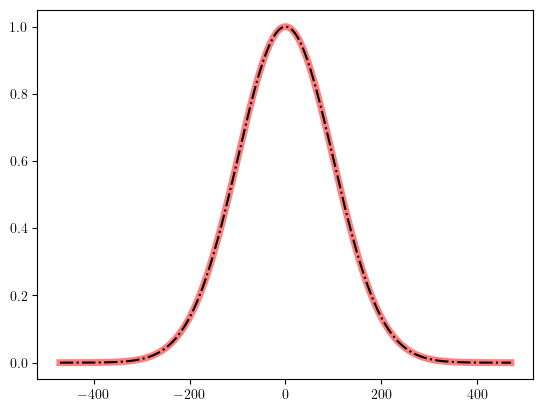

In [126]:
plt.plot(k,np.abs(f_t),'r-',lw=5,alpha=0.5)
plt.plot(k,F(k,sig=0.01),'k-.')
plt.show()

In [ ]:
x,x0,y,t,a = sp.symbols(r'x x_0 y t a',real=True)
sig,hbar,m = sp.symbols(r'\sigma h m',real=True,positive=True)

In [ ]:
K = sp.sqrt(a/t)*sp.exp(-a*(x-y)**2/t)
psi0 = (2*sp.pi*sig**2)**(-1/sp.S(4))*sp.exp(-(x-x0)**2/(4*sig**2))

In [ ]:
psi = sp.integrate(K*psi0.subs(x,y),(y,-sp.oo,sp.oo)).args[0][0].simplify()

In [ ]:
u,u0,tau = sp.symbols(r'u u_0 \tau',real=True)

In [ ]:
psi = psi.subs(x,sig*u).subs(x0,sig*u0).simplify().subs(t,hbar*tau/(2*m*sig**2)).simplify().subs(a,m/(2*sp.pi*sp.I*hbar)).simplify().expand().simplify()

In [ ]:
psi.conjugate()*psi.expand().simplify()

In [ ]:
psi0